# 1. Setup

### Install Dependencies

In [51]:
# !pip install tensorflow opencv-python matplotlib

### Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 
import tensorflow as tf
# LAYER ALLOWS TO DEFINE CUSTOM LAYER
# CONV2D --- ALLOWS TO PERFORM CONVOLUTION (CONVOLUTIONAL NEURAL NETWORK)
# DENSE --- GIVES US FULLY CONNECTED LAYER 
# MAXPOOLING2D --- ALLOWS US TO PULL OUR LAYERS TOGETHER AND EFFECTIVELY SHRINKS THE INFORMATION
# INPUT --- DEFINES WHAT WE ARE PASSING THROUGH OUR MODEL 
# FLATTEN --- CONVERTS IN SINGLE DIMENSION

### Create Folder Structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive') #positive image is the image which  match to input image
NEG_PATH = os.path.join('data', 'negative') #negative image is the image which dose not match to input image
ANC_PATH = os.path.join('data', 'anchor') #anchor is input image

In [3]:
# # Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# Collect Positives and Anchors

### Untar Labelled Faces in the Wild Dataset

In [4]:
#dataset link for negative images

# http://vis-www.cs.umass.edu/lfw/ 


In [5]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [9]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

### Collect Positive and Anchor Classes

In [4]:
# Import uuid library to generate unique image names
import uuid # UUID-----> Universally unique identifier

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) #UNIQUE IMAGE NAME

'data\\anchor\\538fe986-7ee6-11ee-a076-e86a642e21d6.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

### Data Augmentation

In [ ]:

def data_aug(img):#  for every single image inside anchor class i went and looped nine times so this meansthat for every anchor and positive image we would now have 10 times as many images including the one that we already had there so we have 9 additional images for every single image we had in there originally and i wenrt and applied 5 different random data augmentation 
    data = [] 
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2)) # increase or decrease brightness
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3)) # increase or decrease contrast
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100))) # flip left or right 
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100))) # improve or decode  the quality of jpeg image that we actually had 
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))# changes the saturation 
            
        data.append(img)
      

        return data

In [15]:
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [16]:
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path = os.path.join(ANC_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

#### Get Image Directories

In [17]:
# using a generator to be able to loop through and grab all of the files within that specific directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000) # grab everything inside anchor path,jpg isliye liha kuinke sari pics jpg me thi agr koi aur extension hon image ki tou wo likhen /* isliye likha take sri cheezen ajain us path se 
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)
# take(300) ---- means 300 image hon ,hum isse kam ya ziada bhi karsakte apni marzi se 

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
print(dir_test.next()) # actually got a full path to a specific image within our directory  
# next every time change the image path 

b'data\\anchor\\7c429cff-012c-11ee-b635-c81f6624b715.jpg'


# 2. Preprocessing - Scale and Resize

In [20]:
# loads image,from our directory ,resize it ,perform scaling ----convert all of the image values 
# to 0-255 to 0-1 this helps our neural network optimize alot easier rather than having huge 
# range of numbers
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [22]:
preprocess('data\\anchor\\7c429cff-012c-11ee-b635-c81f6624b715.jpg') # copy the path from above 

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.30661765, 0.33848038, 0.42328432],
        [0.67034316, 0.6727941 , 0.7142157 ],
        [0.80588233, 0.80857843, 0.8007353 ],
        ...,
        [0.03431373, 0.03039216, 0.01470588],
        [0.0382353 , 0.03431373, 0.01568628],
        [0.0382353 , 0.03431373, 0.01862745]],

       [[0.31960785, 0.35367647, 0.41715688],
        [0.48480392, 0.55465686, 0.5808824 ],
        [0.75      , 0.8154412 , 0.82916665],
        ...,
        [0.04215686, 0.0382353 , 0.01862745],
        [0.03848039, 0.03602941, 0.01568628],
        [0.04313726, 0.03921569, 0.01960784]],

       [[0.3752451 , 0.42622548, 0.44411764],
        [0.53137255, 0.5776961 , 0.5897059 ],
        [0.7583333 , 0.8122549 , 0.83504903],
        ...,
        [0.03848039, 0.04044118, 0.01789216],
        [0.03553922, 0.03897059, 0.01789216],
        [0.03455883, 0.03921569, 0.01862745]],

       ...,

       [[0.93308824, 0.8495098 , 0.40661764],
        [0.94

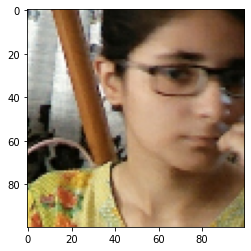

In [24]:
img = preprocess('data\\anchor\\7c429cff-012c-11ee-b635-c81f6624b715.jpg')
plt.imshow(img)

In [25]:
img.numpy().max()  # max pixel value 1 arahi jo hum chahte the ke 0-1 ke darmiyan values hojain 

1.0

In [26]:
img.numpy().min() # min pixel value 0 arahi jo hum chahte the ke 0-1 ke darmiyan values hojain 

0.0

### Create Labelled Dataset

In [27]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [28]:
tf.ones(len(anchor))

<tf.Tensor: shape=(632,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [29]:
# directories concatenated together 
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) # for varified
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))# for not variied 
data = positives.concatenate(negatives)
# e actually got one big dataset which it has the shape of so it will be our anchor images or 
# either positive images or negative file paths or either its going to be one or zeros

In [30]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [31]:
samples = data.as_numpy_iterator()

In [32]:
samples.next() # this is one sample of our data

(b'data\\anchor\\106c0041-012c-11ee-9275-c81f6624b715.jpg',
 b'data\\positive\\78891912-012c-11ee-ad5c-c81f6624b715.jpg',
 1.0)

In [33]:
exampple = samples.next() # ye next bar bar run karne se image change hoti hai yahan bhihorahi par ye pehle sari positive wali ke paths aarahe phr jab positive images khatam hongi tab negative ke paths aainge isliye humme data shuffle karna hoga jo hum agay karenge

In [34]:
exampple

(b'data\\anchor\\7c4757b1-012c-11ee-bb86-c81f6624b715.jpg',
 b'data\\positive\\7a3769c1-012c-11ee-9e29-c81f6624b715.jpg',
 1.0)

# 3.  Build Train and Test Partition

In [35]:
def preprocess_twin(input_img, validation_img, label):# twin preprocessing function 
    return(preprocess(input_img), preprocess(validation_img), label)
# ye function prediction ke liye hai input img matlab anchor  image aur ye validation img
# positive image bhi hoskati aur negative bhi 

In [36]:
preprocess_twin(*exampple) # * isliye lagaya take ye path ko extract karle (unpack) karle khud se

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.03627451, 0.03235294, 0.01666667],
         [0.04019608, 0.03627451, 0.01960784],
         [0.03946079, 0.03553922, 0.01593137],
         ...,
         [0.7487745 , 0.779902  , 0.78063726],
         [0.68602943, 0.7085784 , 0.7497549 ],
         [0.3009804 , 0.33161765, 0.40808824]],
 
        [[0.02745098, 0.03235294, 0.01470588],
         [0.02941176, 0.03431373, 0.01666667],
         [0.02941176, 0.03431373, 0.01519608],
         ...,
         [0.7289216 , 0.7987745 , 0.8007353 ],
         [0.47941175, 0.53455883, 0.5620098 ],
         [0.33112746, 0.38137254, 0.43529412]],
 
        [[0.02745098, 0.03529412, 0.02352941],
         [0.02426471, 0.03210784, 0.02034314],
         [0.03259804, 0.0382353 , 0.02058824],
         ...,
         [0.7343137 , 0.79313725, 0.79313725],
         [0.51985294, 0.5757353 , 0.5830882 ],
         [0.40980393, 0.47867647, 0.5004902 ]],
 
        ...,
 
        [[0.5242647 , 0.4497549 

In [37]:
res = preprocess_twin(*exampple)

In [38]:
len(res)

3

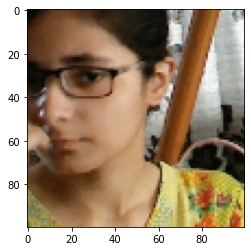

In [39]:
plt.imshow(res[0])

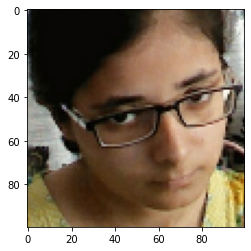

In [40]:
plt.imshow(res[1])

In [41]:
res[2]

1.0

In [42]:
# ooper teeno images meri hain matlab ye positive hai ye 3 values iliye deraha kuinke humne
# preprocess ke function me 3 channels likha tha 

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()# caching imaging 
data = data.shuffle(buffer_size=10000)# shuffle data ---is liye kia take mix set hon samples ka matlab positive negative sari images mix hojian kuinke agay training aur testing me break nkarna hoga humme 

In [44]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [45]:
samples = data.as_numpy_iterator()
samples.next()

(array([[[0.31813726, 0.3492647 , 0.43676472],
         [0.6632353 , 0.68921566, 0.7115196 ],
         [0.8034314 , 0.8335784 , 0.8303922 ],
         ...,
         [0.03529412, 0.03137255, 0.02352941],
         [0.03700981, 0.03308824, 0.0252451 ],
         [0.05686275, 0.05294118, 0.04509804]],
 
        [[0.35196078, 0.38039216, 0.44558823],
         [0.5125    , 0.54264706, 0.60808825],
         [0.79240197, 0.8338235 , 0.85612744],
         ...,
         [0.03921569, 0.03529412, 0.02745098],
         [0.03627451, 0.03235294, 0.0245098 ],
         [0.05392157, 0.05      , 0.04215686]],
 
        [[0.40612745, 0.45808825, 0.475     ],
         [0.5362745 , 0.5735294 , 0.5901961 ],
         [0.7860294 , 0.8161765 , 0.82867646],
         ...,
         [0.03627451, 0.03235294, 0.0245098 ],
         [0.03308824, 0.02916667, 0.02132353],
         [0.03259804, 0.02867647, 0.02083333]],
 
        ...,
 
        [[0.81421566, 0.64362746, 0.21642157],
         [0.907598  , 0.79583335, 0.38897

In [46]:
len(samples.next()) # 3 means first is anchor image ,2nd wwill be either positive or negative and 3rd value is label means decision if anchor image and positive image then 1 ,if anchor image and negative image then 0 

3

In [47]:
sam = samples.next()

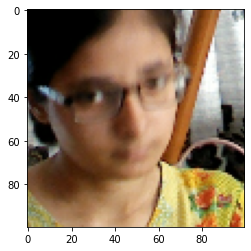

In [48]:
plt.imshow(sam[0])

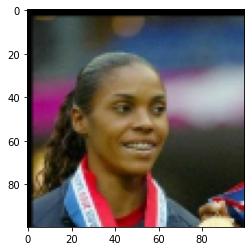

In [49]:
plt.imshow(sam[1])

In [50]:
# the first image is input image means anchor image 2nd one is negative image so the label is zero
sam[2]

0.0

In [51]:
# Training partition
train_data = data.take(round(len(data)*.7)) # take --- grabs the certain percentage of our dataset 
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [52]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
train_sample

(array([[[[0.03921569, 0.03137255, 0.03529412],
          [0.03529412, 0.03627451, 0.0254902 ],
          [0.03235294, 0.03921569, 0.01960784],
          ...,
          [0.7536765 , 0.8232843 , 0.81666666],
          [0.6107843 , 0.6372549 , 0.68333334],
          [0.24509804, 0.2497549 , 0.35931373]],
 
         [[0.03921569, 0.03235294, 0.03333334],
          [0.03529412, 0.03627451, 0.0254902 ],
          [0.03235294, 0.03921569, 0.01960784],
          ...,
          [0.7151961 , 0.7757353 , 0.8066176 ],
          [0.4735294 , 0.50392157, 0.56715685],
          [0.3526961 , 0.37034315, 0.4732843 ]],
 
         [[0.03921569, 0.03529412, 0.02745098],
          [0.03529412, 0.03627451, 0.0254902 ],
          [0.03455883, 0.03921569, 0.01960784],
          ...,
          [0.7357843 , 0.777451  , 0.7862745 ],
          [0.5372549 , 0.5747549 , 0.5901961 ],
          [0.47107843, 0.5095588 , 0.54558825]],
 
         ...,
 
         [[0.59436274, 0.5747549 , 0.31004903],
          [0.56740

In [53]:
len(train_sample[0]) # training partition ke baad 1 sample me 16 images hongi

16

In [54]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

### Build Embedding Layer

In [55]:
inp = Input(shape=(100,100,3), name='input_image')#creating input layer we define shape of input image as 100 by 100 pixels  and 3 channels
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [56]:

c1 = Conv2D(64, (10,10), activation='relu')(inp) # creating convolutional layer ,64 pixels then specified shape that we want 10 by 10 pixels,then apply activation function relu,then in order to pass through or start connecting our neural network together we are grabbing our input and we are passing it through to our convolutional layer   
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [57]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1) # creating max pooling layer ,64 units then shape 2 by 2 ,so its effectively going to take the maximum  value of 2 by 2 area and returns the max value,padding is used in order to replicate similar output shape ,then pasing convoltional layer
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [58]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
print(c2)
print(m2)

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [59]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
print(c3)
print(m3)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 128), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")


In [60]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4) # flatten karraha c4 ko   256*4*4 = 9216 is value ko latten karraha ye ,ye isliye karrahe take hum single demension me le aain values ko 
d1 = Dense(4096, activation='sigmoid')(f1)
print(c4)
print()
print(d1)
print()
print(f1)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_3/Relu:0', description="created by layer 'conv2d_3'")

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")

KerasTensor(type_spec=TensorSpec(shape=(None, 9216), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")


In [61]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [62]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [63]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [64]:
embedding = make_embedding()

In [65]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

### Build Distance Layer

In [66]:
# Siamese L1 Distance class
class L1Dist(Layer): # layer isthe abstracted class or the base class for our keras layers
    
    # Init method - inheritance
    def __init__(self, **kwargs):  # **kwargs this allows you to work with this specific layer as part of a bigger model so when it comes to actually exporting and importing this having this actaully definedmakes your life alot easier,so when we actually go to export it we are actually going to use the abstracted versions, **kwargs passing this through means that if we wanted to go and pass through specific keyword arguments its going to handle them innately  
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding): # call function actually tells this layer what to do when some data is passed to it 
        return tf.math.abs(input_embedding - validation_embedding)

In [67]:
l1 = L1Dist()

In [68]:
# l1(input_embedding, validation_embedding)

# Make Siamese Model

In [69]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [70]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [71]:
siamese_layer = L1Dist()

In [72]:
distances = siamese_layer(inp_embedding, val_embedding)

In [73]:
classifier = Dense(1, activation='sigmoid')(distances)

In [74]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [75]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [76]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [77]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [78]:
siamese_model = make_siamese_model()

In [79]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

### Setup Loss and Optimizer 
###### setup loss for minimizing loss and optimizer for back propagation to our custom neural network

In [80]:
binary_cross_loss = tf.losses.BinaryCrossentropy()      # loss function 

In [81]:
opt = tf.keras.optimizers.Adam(1e-4) # 1e-4 = 0.0001 ----learning rate    # optimizer (here we use adam optimizer)

### Establish Checkpoints
###### means when something screws up in our neural network as we are training we have got almost like a place holder to reload our neural network from 

In [82]:
checkpoint_dir = './training_checkpoints' # we have defined a directory where we are going to 
# save all our checkpoints and this is going to be called training_checkpoints,but we cannot 
# defined this directory in our folder so go and make a folder  and name it training_checkpoints,
# inside this folder we actually building our model ,./ basically represents us from the current
# folder we are going to go in to our training check points folder and save our stuff down here.

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') # we have defined it as being inside of 
# our checkpoint directory and we are going to prefix all of our checkpoints with ckpt so this
# basically means that we are going to have all of  our checpoints in a consistent format they
# will start with ckpt and then normally they will build end with a set of unique numbers or 
# effectively it goes in sequence so 001 or 002 so on and so fourth. 

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model) # define what we actually
# want to save out ,opt=optimizer ,we are going to be saving out these two components 
# (optimizer and siamese model) as  our set of check points now we could probably save our model. 

### Build Train Step Function
###### defines what we happen when we train on a single batch 

###### the basic flow of training on one batch is as follows:
###### 1. Make a prediction
###### 2. Calculate Loss
###### 3. Derive gradients 
###### 4. Calculate new weights and apply 

In [83]:
test_batch = train_data.as_numpy_iterator()

In [84]:
batch_1 = test_batch.next()

In [85]:
len(batch_1)

3

In [86]:
batch_1[0] # anchor image 

array([[[[0.00000000e+00, 2.20588245e-03, 3.43137258e-03],
         [0.00000000e+00, 2.94117653e-03, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [7.44362772e-01, 7.76225507e-01, 7.73529410e-01],
         [7.01715708e-01, 6.84803903e-01, 7.39950955e-01],
         [2.91911751e-01, 3.36274505e-01, 4.63725477e-01]],

        [[9.80392215e-04, 0.00000000e+00, 0.00000000e+00],
         [7.35294132e-04, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 2.94117653e-03, 0.00000000e+00],
         ...,
         [7.13480413e-01, 7.88480401e-01, 8.16666663e-01],
         [4.96813715e-01, 5.44852912e-01, 6.00490212e-01],
         [3.15441191e-01, 3.62254888e-01, 4.26960796e-01]],

        [[9.80392215e-04, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.67647060e-03, 0.00000000e+00],
         ...,
         [7.34558821e-01, 7.86029398e-01, 8.34313750e-01],
         [

In [87]:
len(batch_1[0])#---anchor image , # inside 1 batch we have 16 images 

16

In [88]:
batch_1[1] # positive or negative image  

array([[[[3.49019617e-01, 1.52941182e-01, 7.84313772e-03],
         [3.52941185e-01, 1.60784319e-01, 3.92156886e-03],
         [3.62009794e-01, 1.61029413e-01, 7.10784318e-03],
         ...,
         [1.94117650e-01, 9.11764726e-02, 4.90196086e-02],
         [1.33333340e-01, 5.19607849e-02, 2.84313727e-02],
         [9.01960805e-02, 2.25490201e-02, 1.37254903e-02]],

        [[3.49019617e-01, 1.52941182e-01, 7.84313772e-03],
         [3.50735307e-01, 1.58578426e-01, 1.71568629e-03],
         [3.58823538e-01, 1.57843143e-01, 3.92156886e-03],
         ...,
         [1.94117650e-01, 9.11764726e-02, 4.90196086e-02],
         [1.33333340e-01, 5.19607849e-02, 2.84313727e-02],
         [8.62745121e-02, 1.86274517e-02, 9.80392192e-03]],

        [[3.55882347e-01, 1.59803927e-01, 1.47058824e-02],
         [3.55882347e-01, 1.63725495e-01, 6.86274515e-03],
         [3.58823538e-01, 1.57843143e-01, 3.92156886e-03],
         ...,
         [1.94117650e-01, 9.11764726e-02, 4.90196086e-02],
         [

In [89]:
len(batch_1[1]) # inside 1 batch we have 16 images 

16

In [90]:
batch_1[2]

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [91]:
X = batch_1[:2]

In [92]:
len(X)

2

In [93]:
np.array(X).shape  # we have 2 components our anchor and either positve or negative image ,each batch is made up of 16 images ,then our shape is 100 by 100 and 3 channels ,so that is all our data stored in X 

(2, 16, 100, 100, 3)

In [94]:
y = batch_1[2]

In [95]:
y # these are all about our labels 

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [96]:
y

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [98]:
@tf.function # we are wrapping the function inside of this at tf function decorator so the reason for this is it actually goes and compiles this pecific training function. @tf actually compiles a function into a collable tensorflow graph .so exactly what we are doing is by using this as  tf.function decorator we  are compiling that what going to  happen under this training step function  
def train_step(batch):# defining our function and pass thrugh one batch of data 
    
    # Record all of our operations 
    with tf.GradientTape() as tape:      # this allows us to atually start capturing our gradients from our neural network model ,it is recording every single thing that is happening inside of our neural network and its trying to look at these functions that weare actually defining to go and perform differntiation 
        # Get anchor and positive/negative image
        X = batch[:2] # we are effectively extrapolating or extracting our batch,grabbing our fetaures 
        # Get label
        y = batch[2] # grabbing our labels
        
        # Forward pass
        yhat = siamese_model(X, training=True) # this actually making a prediction ,we are actually passing some data to our siamese model , training=True is necessary because some layers are going to activate when this actually set to true  
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)# calculaing all the gradients for our differnet weights within our specific model with respect to our loss,this is actually starting to use a tape that recorded all of our operations throughour neural network to go and calculate our gradients ,tape.gradient rthen we are grabbing oiur loss and we are going and calculating all of the gradients for all of the different trainable variables inside of our neural network and specifically the siamese model which is our neural network ,first position argument is our loss then we are basically saying calculate all of our gradients with respect to this of our trainable variables second positional argument is siamese_model.trainable_variables in order to calculate our updated weights  
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))# our optimizer is actually appling our learning rate and slightly reducing the loss by changing our weights to be a little bit closer to the global optima
        
    # Return loss
    return loss

### Build Training Loop
###### effective going through every single batch for every single epoch and applying our training step,training step get applied per batch  a training loop does it over our entire dataset over over the entire set of epochs

In [99]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [100]:
# while the training step function was focussed on training for one batch ,the loop here will be used to iterate over every batch  in the dataset def train(data, EPOCHS):
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):# WE START WITH EPOCH 1 THEN INCREMENT IN EPOCH OTHERWISE IT STARTS FROM XERO 
        print('\n Epoch {}/{}'.format(epoch, EPOCHS)) # GIVE US STATUS UPDATE 
        progbar = tf.keras.utils.Progbar(len(data)) # PROGRESS BAR WHERE I SORT OF SAID THAT IF YOU WRAP THIS INSIDE OF A MODEL CLASS YOU DONT HAVE TO THIS EXPLICITLY THE NATIVE API JUST DOES IT FOR YOU BUT AGAIN THIS GIVES YOU A LITTLE BIT MORE CONTROL  
        
         # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data): # THIS GIVES US COUNTER AND THE ACTUAL BATCH ITSELF 
            # Run train step here
           
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
    
        
        # Save checkpoints
        if epoch % 1 == 0: # WE ARE GOING TO SAVE IT EVERY 10 EPOCHS AGAIN 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [101]:
EPOCHS = 1

In [102]:
train(train_data, EPOCHS)


 Epoch 1/1
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
56/56 [==============================] - 1196s 21s/step
0.0005829499 0.83916086 0.96256685


# 6. Evaluate Model


###  Import Metrics

In [103]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
# precision demonstrates what proportion of positive identification were actually correct
# recall shows what proportion of actual positives were identified correctly

### Make Predictions

In [104]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [105]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[1.0388424e-03],
       [5.4566840e-06],
       [9.3187839e-01],
       [4.5133472e-04],
       [2.1237578e-02],
       [9.9817026e-01],
       [9.9388391e-01],
       [6.5416535e-03],
       [4.4027802e-02],
       [9.7631818e-01],
       [1.2920346e-03],
       [7.4187796e-05],
       [3.2072461e-05],
       [9.1922742e-01],
       [9.9943054e-01],
       [1.1705154e-03]], dtype=float32)

In [106]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ] # we covery above output to 0 and 1

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]

In [107]:

y_true # takreeban same aya hai result ooper  wale se ooper wala predicted answwer hai aur ye wala actual

array([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

### Calculate Metrics


In [108]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [109]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

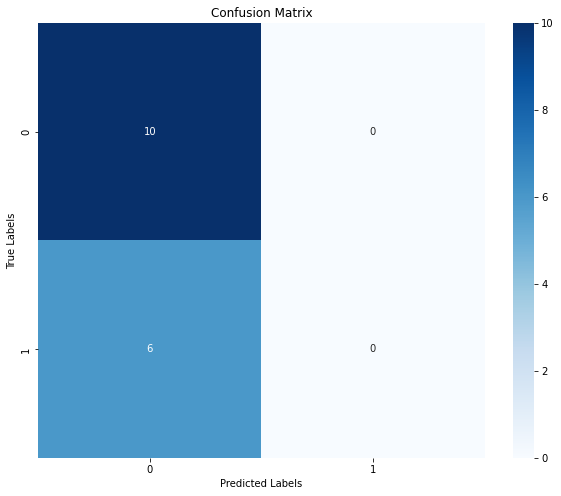

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77        10
         1.0       0.00      0.00      0.00         6

    accuracy                           0.62        16
   macro avg       0.31      0.50      0.38        16
weighted avg       0.39      0.62      0.48        16



C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classif

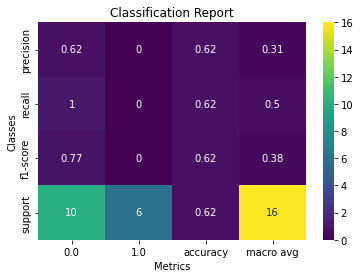

In [115]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert predicted labels to binary format
y_hat_binary = np.argmax(y_hat, axis=1)

# Calculate and plot confusion matrix
cm = confusion_matrix(y_true, y_hat_binary)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_hat_binary)
print("Classification Report:")
print(report)
# Plot classification report
report_data = classification_report(y_true, y_hat_binary, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="viridis")
plt.xlabel("Metrics")

plt.ylabel("Classes")
plt.title("Classification Report")
plt.show()

In [105]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 439ms/step
0.89830506 1.0


### Viz Results

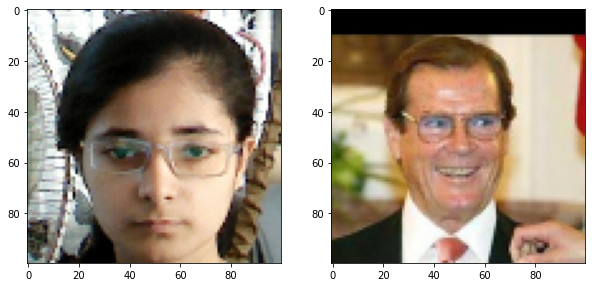

In [106]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)# 1row ,2 column ,1 index
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2) # 1row ,2 column ,2 index
plt.imshow(test_val[0])

# Renders cleanly
plt.show()
#[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1] --- isme jo pehla 0 hai ye uska bataraha ke matlab 0  hai pehle wale me tou negative hogi aik pic dosre wale me bhi negative hogi agr index 2 rakhenge tou positive aaigi kuinke 1 hai 

# 7. Save Model

In [107]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [108]:
L1Dist

__main__.L1Dist

In [109]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [110]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 557ms/step


array([[3.2092526e-06],
       [3.3388269e-04],
       [1.2503042e-03],
       [9.3125945e-01]], dtype=float32)

In [111]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8.  Real Time Test

### Verification Function

In [112]:
# humne aik folder banaya hai application data ka jisme verification images aur input images ke 2 folders hain jisame 
# se verificate images ke folder me humne positive image ke folder se 50 images randomly uthai hai  aur verification images
# me dali hai ,hum 50 se ziada bhi le sakte the par yaad rahe jitni images hongi verification utni slow hogi

In [113]:
# application_data\verification_images

In [114]:
os.listdir(os.path.join('application_data', 'verification_images'))

['WhatsApp Image 2023-04-21 at 4.41.38 PM (1).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (2).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (3).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (4).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (5).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (6).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (7).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (8).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM (9).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.38 PM.jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (1).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (10).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (11).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (12).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (13).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (14).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (15).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (16).jpeg',
 'WhatsApp Image 2023-04-21 at 4.41.39 PM (

In [115]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [116]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (1).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (2).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (3).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (4).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (5).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (6).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (7).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (8).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM (9).jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.38 PM.jpeg
application_data\verification_images\WhatsApp Image 2023-04-21 at 4.41.39 PM (1).jpeg
application_data\verification_images\WhatsApp Image 2023-0

In [121]:
def verify(model, detection_threshold, verification_threshold): # model is our siamese neural network,deection threshold is a metric above which a prediciton is considered positive,Verification Threshold: Proportion of positive predictions / total positive samples 
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):# looping every image inside verification folder 
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified =  verification > verification_threshold
           
    
    return results, verified

# OpenCV Real Time Verification

In [122]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 194ms/step
True
1/1 [==============================] - 0s 207ms/step
False
1/1 [==============================] - 0s 195ms/step
True
1/1 [==============================] - 0s 201ms/step
True
1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 193ms/step
True
1/1 [==============================] - 0s 197ms/step
True


In [130]:

np.sum(np.squeeze(results) > 0.5)

44

In [ ]:
results

In [131]:
44/50

0.88